## Apiux & SII: Propagacion de contaminacion de contribuyentes en la malla comercial.

## Henry Vega (henrry.vega@api-ux.com)
## Data scientist

Para poder realizar una propagacion de riesgo, consideraremos que éste se puede propagar debido a una influencia directa de un contribuyente sobre otro. Por ejemplo, al considerar una relación patrimonial o familiar, o debido a un impacto indirecto, como al considerar una relación comercial donde por ejemplo si una de las partes en la relación no cumple de forma correcta todas sus obligaciones tributarias podría afectar a que la otra parte no cumpla o cumpla parcialmente con las suyas, luego en este caso no hay un influencia directa en el comportamiento del contribuyente contaminado, sino que la contaminación se da de forma indirecta. En el caso de este algoritmo propuesto, se consideran las relaciones comerciales, considerando el IVA de las transacciones de una entidad con otra. Junto con las fuerzas de relaciones, hay un valor de contaminacion que inicialmente es 0 o 1 para cada entidad (considerando que ya estaba contaminado en base a alguna alerta o no lo esta). La propagacion se ejecuta con estas condiciones iniciales.

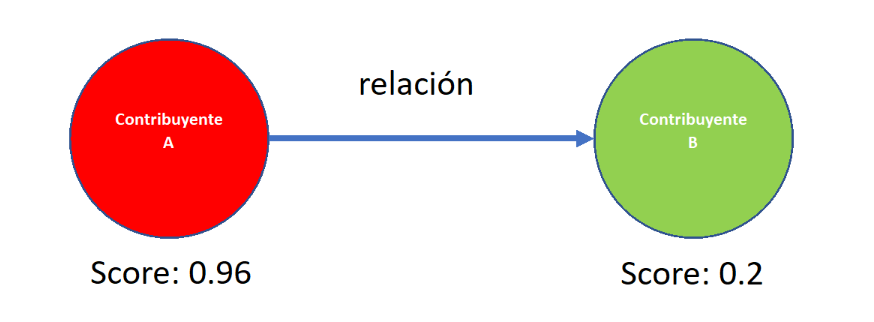

La fuerza entre entidades tiene la condicion de creacion de estar en el rango [0,1].

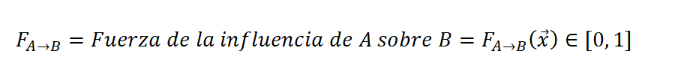

Eventualmente, muchas entidades A se pueden relacionar comercialmente con B, segn el siguiente diagrama. De esta forma se tendira que actualizar el valor de scoring de B de acuerdo a los valores de scoring de A y las fuerzas correspondientes.
Como ejemplo, consideremos tres entidades A que se han relacionado comercialmente con una entidad B. 

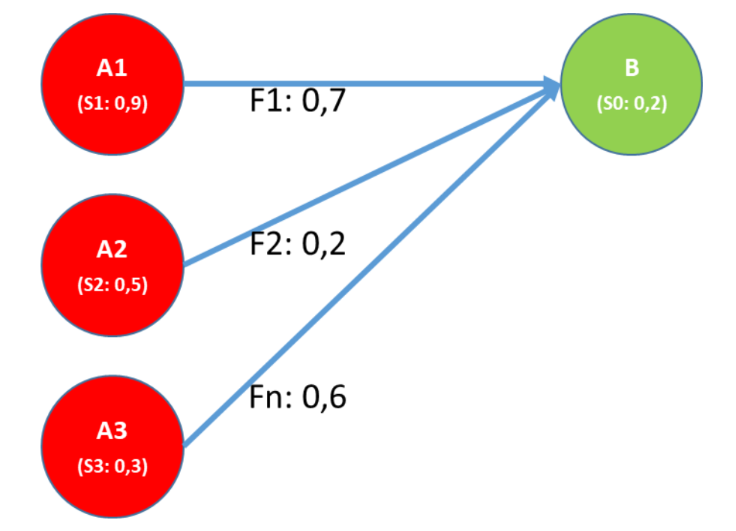

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "24g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "12") \
  .config("spark.executor.instances", "24") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')

24/01/15 14:57:07 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/01/15 14:57:08 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
Setting spark.hadoop.yarn.resourcemanager.principal to hvega.externo
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/15 14:57:08 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/01/1

En primer lugar, leemos la data de los arcos comerciales correspondientes.

A partir de la información anterior, calculamos que el 0.98 % de todos los Monto_IVA tienen valores cero o negativos. Ahora comparemos los montos.

El algoritmo se basa en establecer la fuerza de las relaciones comerciales entre entidades. La propagacion de contaminacion se hara hacia adelante, es decir lo receptores de factura son contaminados por las entidades emisoras. 
na fuerza de contaminacion.  

Leemos la data de fuerza a partir de los datos procesados.

In [3]:
spark.read.options(header=True,inferSchema=True,delimiter=",").csv("data/processed/fuerza_iva.csv").createOrReplaceTempView("fuerza")

In [4]:
spark.sql("SELECT count(*)  from fuerza").show() 

+--------+
|count(1)|
+--------+
|42059697|
+--------+



In [5]:
#En las siguientes lineas podemos ver la transformacion de la data basada en las operaciones matematicas descritas en la portada del proyecto

spark.sql("SELECT receptor ,(EXP(SUM(LN(NULLIF(ABS(1-Fi),0))))) AS f0 ,sum(Fi) as sFi from  fuerza group by receptor order by receptor asc ").createOrReplaceTempView("fuerza_aux")
# spark.sql("SELECT *  from fuerza_aux").show() 
spark.sql("SELECT emisor,  fuerza.receptor,Fi,f0,sFi from fuerza left join fuerza_aux on fuerza.receptor=fuerza_aux.receptor").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
spark.sql("SELECT emisor,receptor, Fi, case when f0 is NULL then 0 else f0 end as f0,sFi from fuerza order by receptor asc").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
spark.sql("SELECT emisor,receptor, Fi,f0, round((1-f0)*Fi,4) as f,sFi from fuerza order by receptor asc").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
# Ahora se agrega una correcion para dividir fi por el tutal de la suma de Fi. En el caso que la fuerza sea cero, no se realiza la division, pero para los otros casos si )de esta forma nos cercioramos de que sea distinto de cero.
spark.sql("SELECT emisor, receptor, Fi, f0, case when f=0 then f else f/sFi end as f from fuerza order by sFi desc").createOrReplaceTempView("fuerza") 
spark.sql("SELECT * from fuerza order by f desc").show() 

+--------------------+--------------------+---+---+---+
|              emisor|            receptor| Fi| f0|  f|
+--------------------+--------------------+---+---+---+
|47oGu5juiHIYcKWSh...|+/3tSXunJDhIPyU8p...|1.0|0.0|1.0|
|yBLcRsoxFU9MX5c0V...|+/swCLqkcH26SWP/h...|1.0|0.0|1.0|
|Rx4SIznv6p6TVO2dS...|++SE0iKD1Krg2EGJm...|1.0|0.0|1.0|
|S0a+Fo2w2p4zbTUMC...|+/khxENkzebLkZgjL...|1.0|0.0|1.0|
|8jyy3GYQ7JCBCNxPR...|+/7oJmfB89gVDjbv0...|1.0|0.0|1.0|
|41vxG5znQHxYqDibA...|++0IjdfEhI/GxaXyd...|1.0|0.0|1.0|
|b8dsh5ev9kVplBjnf...|+/AIAXxC3vgygwSc4...|1.0|0.0|1.0|
|ZWAVsd2iLqIH/4/qg...|++dqSnShtg+Ule0bs...|1.0|0.0|1.0|
|g+qp0UCX8YmXLTG2d...|+/B0plzAI6l91gFO6...|1.0|0.0|1.0|
|lW+JOnxQ5q+Mbcdt7...|++eciNC5PhS1Vx5ku...|1.0|0.0|1.0|
|Go3IV6blhnGzCsY/9...|+/CmSwCv8e3JjEOLA...|1.0|0.0|1.0|
|yg16qMZet2lq23LbF...|++OO5C/MejC/chYkZ...|1.0|0.0|1.0|
|2EBOF0puGZPWdSNq2...|+/DXGIZuhz8FtgJ0k...|1.0|0.0|1.0|
|JU0AWZuwpsnrLY9De...|++xNa6TuS6r5G0aVa...|1.0|0.0|1.0|
|Pn1oFMN6vJsn1Lm2K...|+/GkmQEkWENN4G+WZ...|1.0|0

In [6]:
spark.sql("SELECT count(*)  from fuerza").show()  

+--------+
|count(1)|
+--------+
|42059697|
+--------+



In [8]:
spark.sql("SELECT emisor as rut from fuerza").createOrReplaceTempView("a")
spark.sql("SELECT receptor as rut from fuerza").createOrReplaceTempView("b")
spark.sql("SELECT rut FROM a UNION ALL SELECT rut FROM b ORDER BY rut asc").createOrReplaceTempView("c")
spark.sql("SELECT distinct(rut) from c").createOrReplaceTempView("c")
spark.sql("SELECT rut, 0 as score_i from c").createOrReplaceTempView("c")
spark.sql("SELECT count(*) from c").show()

+--------+
|count(1)|
+--------+
| 4327501|
+--------+



In [ ]:
df = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("data/processed/contaminados.csv")
df.createOrReplaceTempView("contaminados")


In [ ]:
spark.sql("SELECT * from c left join contaminados on c.rut=contaminados.cont_rut").createOrReplaceTempView("contaminados")

In [ ]:
contaminados=spark.sql("SELECT rut as cont_rut, case when score is not null and score>score_i then score else score_i end as score from contaminados")

In [ ]:
contaminados_total=contaminados.toPandas()
contaminados_total.to_csv('data/processed/contaminados_processed_iva.csv', index=False)

In [ ]:
performance = pd.DataFrame(columns=['iterations', 'new_values'])

for a in range (0,15): 
#   spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/riesgo_contaminacion").createOrReplaceTempView("contaminados")
    spark.read.options(header=True,inferSchema=True,delimiter=",").csv("data/processed/contaminados_processed_iva.csv").createOrReplaceTempView("contaminados")
    
    spark.sql("SELECT EMISOR, score as score_socio, RECEPTOR,f0,f from fuerza left join contaminados on fuerza.EMISOR=contaminados.cont_rut").createOrReplaceTempView("aux")
    spark.sql("SELECT * from aux left join contaminados on aux.RECEPTOR=contaminados.cont_rut").createOrReplaceTempView("aux")
    spark.sql("SELECT EMISOR,aux.RECEPTOR as RECEPTOR ,f,f0, score_socio, case when score is null then 0 else score end as score_entidad from aux order by aux.RECEPTOR desc").createOrReplaceTempView("aux")
    spark.sql("SELECT RECEPTOR, SUM(f*score_socio) as sum1, AVG(f0*score_entidad) as sum2 from aux group by RECEPTOR ").createOrReplaceTempView("aux")
    spark.sql("SELECT RECEPTOR, (sum1+sum2) as score1 from aux group ").createOrReplaceTempView("aux")
    spark.sql("SELECT * from contaminados left join aux on contaminados.cont_rut=aux.RECEPTOR").createOrReplaceTempView("aux")
    spark.sql("SELECT aux.cont_rut as cont_rut, case when score1>score and score1 is not null then score1 else score end as score from aux").createOrReplaceTempView("contaminados")
    contaminados=spark.sql("select * from contaminados ")
#   raw_path='abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/riesgo_contaminacion'
#   contaminados.write.format("parquet").mode('overwrite').save(raw_path) 
    contaminados=contaminados.toPandas()
    contaminados.to_csv('data/processed/contaminados_processed_iva.csv', index=False)
    b=len(contaminados[(contaminados['score']>0.5) & (contaminados['score']<1)])
    print(len(contaminados[(contaminados['score']>0.1) & (contaminados['score']<1)]))
    print(b)
    
    new_row = {"iterations": a+1, "new_values": b}
    performance=pd.concat([performance,pd.DataFrame([new_row])], ignore_index=True)
    
    print(contaminados.describe())
    
    plt.hist(contaminados[contaminados['score']>0.1]['score'], bins=10)
    plt.title('Histograma  de performance de valores de contaminacion propagados')
    plt.xlabel('Score')
    plt.ylabel('Frecuencia')

    plt.show()
    
performance.plot(x="iterations", y="new_values", kind="bar")


In [ ]:
spark.sql("SELECT count(*) from contaminados").show()

Ahora copiaremos en el archivo de contaminados solo los valores que no hayan sido identificados inicialmente como alertas.

In [ ]:
# En este script, guardamos todos los valores de contaminacion, incluyendo aquellos con alerta inicial. 
# Esta base de datos se utilizara posteriormente en visualizacion de grafos, de ahi de mantener
# la base completa para tambien incluir estos nodos iniciales. 

spark.sql("select * from contaminados ").toPandas().to_csv('/home/cdsw/data/processed/contaminados_processed_iva_total.csv', index=False)

In [ ]:
df = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("/home/cdsw/data/processed/contaminados.csv")
#Valores totales de contaminados incluyendo las entidades con alerta
spark.sql("select count(*) from contaminados ").show()
df.createOrReplaceTempView("contaminados_inicial")
spark.sql("select contaminados.cont_rut as contaminados, round(contaminados.score,3) as score from contaminados left join contaminados_inicial on contaminados.cont_rut=contaminados_inicial.cont_rut where contaminados_inicial.cont_rut is null ").createOrReplaceTempView("contaminados")
contaminados=spark.sql("select * from contaminados ")
#Valores encontrados sin considerar las entidades con alerta
spark.sql("select count(*) from contaminados ").show()
contaminados=contaminados.toPandas()
#Se guarda el archivo con las entidades correspondientes
contaminados.to_csv('/home/cdsw/data/processed/contaminados_processed_iva.csv', index=False)